In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch

from src.config import CONFIG
from src.dataset import SBICDataset
from src.train_utils import * 
# from src.train_utils import make_tokinzer, make_model, make_dataloader, evaluate
from src.utils import print_evaluation_results

2023-11-20 11:20:01.615665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 11:20:02.302154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [55]:
tokenizer = make_tokinzer(CONFIG.hp)
model = make_model(CONFIG.hp, tokenizer)
checkpoints = "distilgpt2_10832_1_sl-half"
model.load_state_dict(torch.load(f"checkpoints/{checkpoints}.pt"))

List of all special token and its token_id:
 - ['<|endoftext|>', '<|sep|>', '<|pad|>', '<|offY|>', '<|offN|>', '<|sexY|>', '<|sexN|>', '<|intY|>', '<|intN|>', '<|grpY|>', '<|grpN|>', '<|ingrpN|>', '<|ingrpY|>']
 - [[50256], [50258], [50257], [50259], [50260], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268]]
Model vocab resize: 50269
Model eos token: 50256
Model pad token: 50257
Model sep token: 50258


<All keys matched successfully>

## Eval classification

train

In [56]:
train_data = get_data("train")[:10832]
dataset = SBICDataset(train_data, tokenizer, is_training=False)
dataloader = make_dataloader(dataset, model, tokenizer, CONFIG.hp, split="validation")

train_res = evaluate_classification(model, tokenizer, dataloader, CONFIG.hp)

  0%|          | 0/1354 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


val

In [57]:
val_data = pd.read_pickle(CONFIG.dataset.val_data_agg).to_numpy()[:1000]
dataset = SBICDataset(val_data, tokenizer, is_training=False)
dataloader = make_dataloader(dataset, model, tokenizer, CONFIG.hp, split="validation")

val_res = evaluate_classification(model, tokenizer, dataloader, CONFIG.hp)

  0%|          | 0/125 [00:00<?, ?it/s]

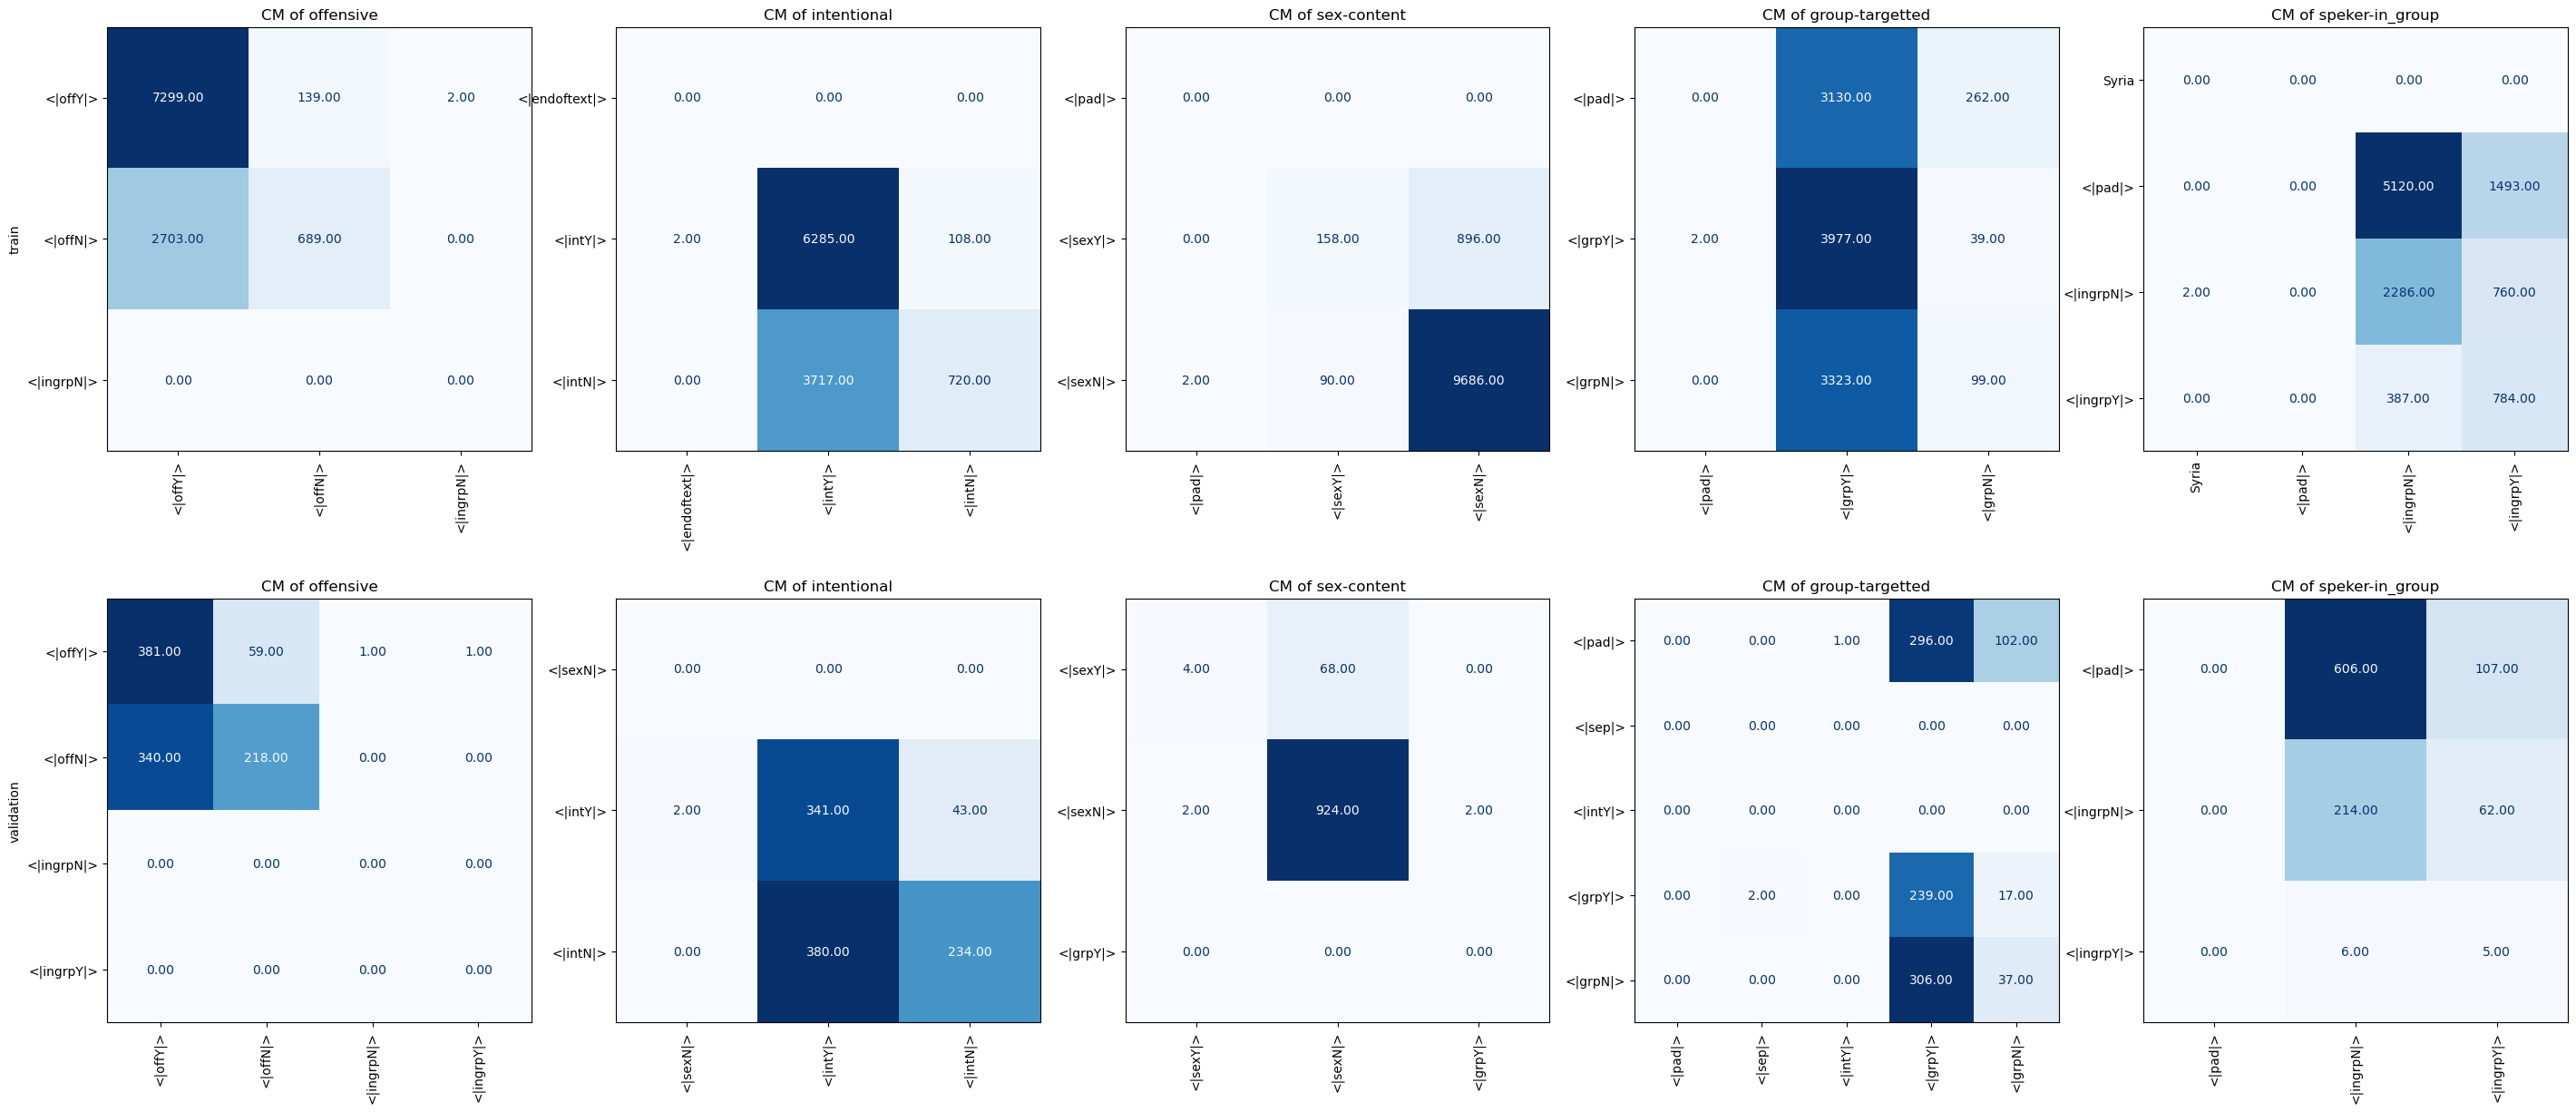

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ['off','int','sex','group','in_group']
splits = ["train", "validation"]
class_types = ["offensive", "intentional", "sex-content", "group-targetted", "speker-in_group"]
results = [train_res, val_res]

fig, axs = plt.subplots(2, 5, figsize=(35, 15))
for i,res in enumerate(results):
    for j in range(5):
        lbl = tokenizer.batch_decode(np.unique(np.concatenate((res["predictions"][j],res["labels"][j]))))
        cm = confusion_matrix(res["labels"][j], res["predictions"][j])
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbl)
        cm_disp.plot(ax=axs[i,j], cmap='Blues',values_format='0.2f', colorbar=False, xticks_rotation=90)
        axs[i,j].set_title(f"CM of {class_types[j]}")
        axs[i,j].set(xlabel=None)
        axs[i,j].set(ylabel=None)
    axs[i,0].set(ylabel=splits[i])
plt.show()

## Eval model

Classification F1 on validation set: avg=0.659
 - Offensive: 0.626
 - Intent: 0.613
 - Sex: 0.802
 - Group: 0.429
 - In-Group: 0.824
 
Minority RougeL-f1 on validation set: 0.553

Stereotype RougeL-f1 on validation set: 0.410

In [3]:
split = "validation"
data = pd.read_pickle(CONFIG.dataset.val_data_agg).to_numpy()[:1000]
dataset = SBICDataset(data, tokenizer, is_training=False)
dataloader = make_dataloader(dataset, model, tokenizer, CONFIG.hp, split="validation")

val_res = evaluate(model, tokenizer, dataloader, CONFIG.hp)

print_evaluation_results(split=split, res=val_res)

  0%|          | 0/125 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                 

Classification F1 on validation set: avg=0.668
 - Offensive: 0.657
 - Intent: 0.637
 - Sex: 0.787
 - Group: 0.430
 - In-Group: 0.829
Minority RougeL-f1 on validation set: 0.572
Stereotype RougeL-f1 on validation set: 0.409


In [6]:
split = "test"
data = pd.read_pickle(CONFIG.dataset.test_data_agg).to_numpy()[:100]
dataset = SBICDataset(data, tokenizer, is_training=False)
dataloader = make_dataloader(dataset, model, tokenizer, CONFIG.hp, split="validation")

test_res = evaluate(model, tokenizer, dataloader, CONFIG.hp)

print_evaluation_results(split=split, res=test_res)

Classification F1 on test set: avg=0.735
 - Offensive: 0.711
 - Intent: 0.676
 - Sex: 0.886
 - Group: 0.709
 - In-Group: 0.692
Minority RougeL-f1 on test set: 0.681
Stereotype RougeL-f1 on test set: 0.421
